<a href="https://colab.research.google.com/github/WhiteFox-Lugh/Pratice-TextAnalysis/blob/master/exercise2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nltkの文章群にscikit-learnを用いてクラスタリングを適用してみる

## 導入編

### 必要なライブラリ・データセットのインポート

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

### 今回は以下のnltkの機能を使用できる様にする


In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

In [3]:
from nltk.corpus import reuters as corpus

### datasetの中身を確認

In [4]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:10]):
    print(item)

ASIAN
EXPORTERS
FEAR
DAMAGE
FROM
U
.
S
.-
JAPAN


### 全document数

In [5]:
len(corpus.fileids())

10788

### (例) 前からk個のdocumentのみで学習する場合

In [6]:
k = 400
docs = [corpus.words(fileid) for fileid in corpus.fileids()[:k]]
tag_arr = corpus.fileids()[:k]
print(tag_arr)

['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843', 'test/14844', 'test/14849', 'test/14852', 'test/14854', 'test/14858', 'test/14859', 'test/14860', 'test/14861', 'test/14862', 'test/14863', 'test/14865', 'test/14867', 'test/14872', 'test/14873', 'test/14875', 'test/14876', 'test/14877', 'test/14881', 'test/14882', 'test/14885', 'test/14886', 'test/14888', 'test/14890', 'test/14891', 'test/14892', 'test/14899', 'test/14900', 'test/14903', 'test/14904', 'test/14907', 'test/14909', 'test/14911', 'test/14912', 'test/14913', 'test/14918', 'test/14919', 'test/14921', 'test/14922', 'test/14923', 'test/14926', 'test/14928', 'test/14930', 'test/14931', 'test/14932', 'test/14933', 'test/14934', 'test/14941', 'test/14943', 'test/14949', 'test/14951', 'test/14954', 'test/14957', 'test/14958', 'test/14959', 'test/14960', 'test/14962', 'test/14963', 'test/14964', 'test/14965', 'test/14967', 'test/14968', 'test

### カテゴリーのチェック

In [7]:
for i in range(5):
  t = tag_arr[i]
  print(corpus.categories(t))

['trade']
['grain']
['crude', 'nat-gas']
['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']
['palm-oil', 'veg-oil']


In [8]:
# カテゴリーのディクショナリ化

docs_category = {}
for i in range(len(corpus.fileids()[:k])):
  cat = tag_arr[i]
  docs_category[cat] = corpus.categories(cat)

## 前処理編

### 例 : ストップワードリストの作成

### nltkのストップワードリスト

In [9]:
en_stop = nltk.corpus.stopwords.words('english')

### 例:【発展】記号や数字は正規表現で消してみる

In [10]:
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         + ["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         + ["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         + en_stop

### 前処理関数の作成

In [11]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力してみる

### 前処理前

In [12]:
print(docs[0][:25]) 

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears']


### 前処理後

In [13]:
print(preprocess_documents(docs)[0][:25])

['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen']


## クラスタリング編

### doc2vec の準備

In [14]:
pre_docs=preprocess_documents(docs)
labeled_sentence = [TaggedDocument(words = pre_docs[n], tags = [tag_arr[n]]) 
                    for n in range(k)]
print(labeled_sentence)

[TaggedDocument(words=['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'official', 'tell', 'reuter', 'correspondent', 'asian', 'capital', 'move', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'lead', 'curb', 'american', 'import', 'product', 'exporter', 'conflict', 'would', 'hurt', 'long', 'run', 'short', 'term', 'tokyo', 'loss', 'might', 'gain', 'impose', '300', 'tariff', 'import', 'japanese', 'electronics', 'good', 'april', '17', 'retaliation', 'japan', 'allege', 'failure', 'stick', 'pact', 'sell', 'semiconductor', 'world', 'market', 'cost', 'unofficial', 'japanese', 'estimate', 'put', 'impact', 'tariff', 'spokesman', 'major', 'electronics', 'firm', 'would', 'virtually', 'halt', 'export', 'product', 'hit', 'new', 'tax', 'able', 'business', 'spokesman', 'leading', 'japanese', 'ele

In [15]:
# モデルの定義
# dm : 1 なら PV-DM を使い、0 なら PV-DBOW を使う
# vector_size : 特徴ベクトルの次元数
# windows : 前後何単語とるか
# min_count : total frequency がこれ未満なら単語を無視する（今回は無視しない）
# alpha : 学習率
model = Doc2Vec(documents = labeled_sentence, dm = 1, vector_size = 50,
                windows = 5, min_count = 1, alpha = 0.0015)

### fitする

In [16]:
# document size の再確認
print(len(pre_docs))

# k-means の入力にする
vecs = [model.docvecs[i] for i in range(len(model.docvecs))]
doc_prefix = [(pre_docs[i][0] + " " + pre_docs[i][1] + " "
 + pre_docs[i][2] + "...") for i in range(len(model.docvecs))]

print(tag_arr[0])
print(doc_prefix[0])
print(vecs[0])

2000
test/14826
asian exporter fear...
[ 0.00922522  0.00441693 -0.00099958 -0.0011618  -0.00901223 -0.00445317
  0.00430531 -0.00448016  0.00409919 -0.00822557  0.0042958  -0.00285684
  0.00537066  0.0057558   0.00681185  0.00604898  0.0001925   0.00186931
  0.00982417 -0.00469326  0.00930789 -0.00232758  0.00095782  0.00477583
  0.00099801  0.00510605  0.00041135  0.00762287  0.00723046 -0.00160218
 -0.00038612  0.00532974 -0.00027696 -0.00238334  0.00762211  0.00957254
 -0.00539225  0.00648591 -0.00935867  0.00927908  0.00978811  0.00687688
 -0.00136821  0.0092535  -0.00957446 -0.00613726  0.0074557   0.00172596
 -0.00976409 -0.00689375]


### K-means
### kmeansの設定

In [17]:
def fun_kmeans(n, v_input):
  # k-means definition
  # n_clusters : クラスタ数
  km = KMeans(n_clusters = n, max_iter = 300, n_init = 10,
              init = 'k-means++', random_state = 0)
  ret = km.fit_predict(v_input)
  ret2 = km.inertia_
  return ret, ret2

In [18]:
def cluster_counter(n, v, clusters_res):
  # クラスタごとのカウント
  cnt = np.zeros(n)

  for j in range(len(v)):
    c = clusters_res[j]
    cnt[c] += 1

  print(cnt)
  return

In [19]:
def show_category(n, cls_res):
  for j in range(n):
    print("Cluster num : " + str(j))
    l = []
    for doc, cls in zip(tag_arr, cls_res):
      if not cls == j:
        continue
      category_arr = docs_category[doc]
      l.extend(category_arr)
    c = collections.Counter(l)
    print(c)
  return

### k-means の k を様々な値にして回す

Cluster Nums -> 1
[2000.]
Cluster num : 0
Counter({'earn': 633, 'acq': 490, 'grain': 118, 'money-fx': 108, 'crude': 105, 'interest': 91, 'trade': 89, 'wheat': 58, 'ship': 45, 'corn': 44, 'dlr': 37, 'oilseed': 34, 'gnp': 32, 'sugar': 30, 'money-supply': 30, 'veg-oil': 27, 'nat-gas': 25, 'soybean': 23, 'bop': 23, 'gold': 22, 'cpi': 22, 'rice': 20, 'livestock': 19, 'alum': 19, 'coffee': 18, 'jobs': 17, 'meal-feed': 17, 'reserves': 16, 'copper': 15, 'gas': 15, 'cocoa': 15, 'carcass': 14, 'cotton': 14, 'barley': 13, 'lead': 12, 'iron-steel': 12, 'tin': 11, 'soy-oil': 11, 'yen': 11, 'strategic-metal': 11, 'orange': 11, 'soy-meal': 11, 'zinc': 10, 'sorghum': 10, 'pet-chem': 10, 'wpi': 10, 'palm-oil': 9, 'ipi': 8, 'fuel': 8, 'rubber': 7, 'platinum': 7, 'income': 7, 'rapeseed': 6, 'silver': 6, 'lumber': 5, 'heat': 5, 'oat': 5, 'groundnut': 4, 'hog': 4, 'rape-oil': 3, 'potato': 3, 'lei': 3, 'sunseed': 2, 'sun-oil': 2, 'retail': 2, 'cotton-oil': 2, 'tea': 2, 'coconut-oil': 2, 'dmk': 2, 'naphtha':

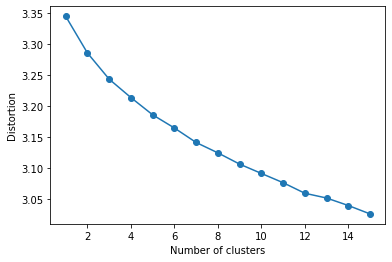

In [20]:
x = np.empty(0)
y = np.empty(0)

for i in range(1, 16, 1):
  print("Cluster Nums -> " + str(i))
  # モデル定義 / fit
  clusters, sse = fun_kmeans(i, vecs)

  # クラスタリング結果表示（数）
  cluster_counter(i, vecs, clusters)

  # タグの表示
  show_category(i, clusters)

  # SSE の表示
  print("Distortion : %.5f"% sse)

  # plot 用
  x = np.append(x, i)
  y = np.append(y, sse)

  print("==========================\n")

plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 応用
<p1>
    クラスタリング編でコードを以下に指示に従って変更する事で結果がどの様に変わるのかを確認してみましょう<br>
    （１）講義で学んだ他の手法でベクトル化してみる(例：bag-of-words)<br>
    （２）kmeans以外の手法、又はkmeansを可視化してみる(例：階層型クラスタリング)<br>
<p1>